# import

In [1]:
import math
import numpy as np
import pylab as plt
plt.style.use('./matplotlib.style')
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
import scipy.io
from tqdm import tqdm
from utils import getR
import sys
sys.path.append('./pytorch_nufft')
from pytorch_nufft import nufft

gyromagnetic_ratio = 42.58 # MHz / T ~ kHz / mT

from typing import List, Tuple, Callable

def gtime(seq: List[Tuple]):
    res = []
    t = 0
    for (dt, n) in seq:
        res.append(np.linspace(t, t + dt * n, n))
        t = t + dt * n
    return np.concatenate(res)

def blochEquationStep(M: torch.Tensor, Rfunc: Callable, M0: torch.Tensor, dt: float, step: int):
    # rotating
    M = torch.matmul(Rfunc(dt, step), M.T[:, :, None])[:, :, 0].T
    # time relaxation
    # M[0] = M[0] * torch.exp(-dt / T2)
    # M[1] = M[1] * torch.exp(-dt / T2)
    # M[2] = M[2] * torch.exp(-dt / T1) + M0 * (1 - torch.exp(-dt / T1))
    return M

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# simualte signal

In [2]:
img = torch.from_numpy(skimage.data.shepp_logan_phantom()[:, :] * 1.0 + 1.0).float()
img = F.interpolate(img[None, None], size=(64, 64), mode='bicubic')[0,0][:, :, None].repeat(1,1,3)
img *= 1. / img.max()
print(img.shape)
rho_map = img[:,:,0]

torch.Size([64, 64, 3])


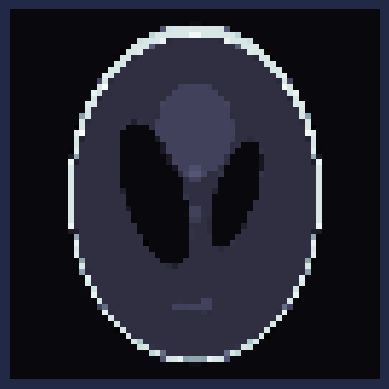

In [3]:
plt.imshow(img[:, :, 0], cmap=plt.cm.bone)
plt.axis(False)
plt.show()

In [4]:
num_isochromats_per_voxel = 1
phases = torch.linspace(-.999, .999, 64)[:, None, None]

M = rho_map.flatten()[None, :].repeat(3, num_isochromats_per_voxel * phases.shape[0])
M[:2] = 0
M += torch.rand_like(M) * 1e-3
M0 = M[2].clone()
efm = []

# B1 field [mT]
x = torch.linspace(-1.0, 1.0, 64) # x [m]
y = torch.linspace(-1.0, 1.0, 64) # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')
Gx = X[None, :, :] * torch.ones_like(phases)
Gx *= 100 / 4
Gx = Gx.flatten()[None, :].repeat(3, num_isochromats_per_voxel)
Gx[:2] = 0
Gy = Y[None, :, :] * phases
Gy *= 100 / 4
Gy = Gy.flatten()[None, :].repeat(3, num_isochromats_per_voxel)
Gy[:2] = 0


# B0 field [mT]
B0 = torch.ones_like(M) * 40
B0[:2] = 0

B0 = B0.cuda()
Gx = Gx.cuda()
Gy = Gy.cuda()
M = M.cuda()
M0 = M0.cuda()

In [5]:
mrec = []

# relax
dt = 1e-1       # [ms]
R = getR(B0, dt)
for i in tqdm(range(50)):
    M = blochEquationStep(M, lambda dt, i: R, M0, dt, i)
    efm += [M.reshape(3, num_isochromats_per_voxel, phases.shape[0], -1)[0].mean(dim=(-1, -3)).cpu()]
# rf90
dt = 1e-5       # [ms]
pbar = tqdm(range(26))
for i in pbar:
    M = blochEquationStep(M, lambda dt, i: getR(B0 + 50 * torch.eye(3, device='cuda')[0][:, None] * math.cos(2 * math.pi * i * dt * 40 * gyromagnetic_ratio), dt), M0, dt, i)
    mrec.append(M[0,0].item())
    angle = torch.atan2(M[2], M[:2].norm(p=2, dim=0)).rad2deg().mean().item()
    pbar.set_description(desc=f'angle: {angle}')
    efm += [M.reshape(3, num_isochromats_per_voxel, phases.shape[0], -1)[0].mean(dim=(-1, -3)).cpu()]
# G- 
dt = 5e-4       # [ms]
pbar = tqdm(range(26))
R = getR(B0 - Gx - Gy, dt)
for i in pbar:
    M = blochEquationStep(M, lambda dt, i: R, M0, dt, i)
    mrec.append(M[0,0].item())
    angle = torch.atan2(M[2], M[:2].norm(p=2, dim=0)).rad2deg().mean().item()
    phasing = (M.mean(dim=1)[:2].norm(p=2) / M0.mean()).item()
    pbar.set_description(desc=f'angle: {round(angle, 1)}\tphasing: {phasing}')
    efm += [M.reshape(3, num_isochromats_per_voxel, phases.shape[0], -1)[0].mean(dim=(-1, -3)).cpu()]
# G+
dt = 15e-5       # [ms]
pbar = tqdm(range(176))
R = getR(B0 + Gx, dt)
for i in pbar:
    M = blochEquationStep(M, lambda dt, i: R, M0, dt, i)
    mrec.append(M[0,0].item())
    angle = torch.atan2(M[2], M[:2].norm(p=2, dim=0)).rad2deg().mean().item()
    phasing = (M.mean(dim=1)[:2].norm(p=2) / M0.mean()).item()
    pbar.set_description(desc=f'angle: {round(angle, 1)}\tphasing: {phasing}')
    efm += [M.reshape(3, num_isochromats_per_voxel, phases.shape[0], -1)[0].mean(dim=(-1, -3)).cpu()]
efm = torch.stack(efm)

angle: 2.7	phasing: 0.00017261537141166627: 100%|██████████| 176/176 [00:00<00:00, 393.52it/s]


In [6]:
# scipy.io.savemat('efm_cartesian.mat', dict(efm=efm.numpy()))
# data = scipy.io.loadmat('efm_cartesian.mat')
# efm = torch.from_numpy(data['efm']).float()

t = torch.linspace(-15e-5 * 88, 15e-5 * 88, 176).cuda()
phases = torch.linspace(-.999, .999, 64)[:, None, None]
x = torch.linspace(-1.0, 1.0, 64) # x [m]
y = torch.linspace(-1.0, 1.0, 64) # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')
Gx = X[None, :, :] * torch.ones_like(phases)
Gx *= 100 / 4
Gx[:2] = 0
Gy = Y[None, :, :] * phases
Gy *= 100 / 4
Gy[:2] = 0

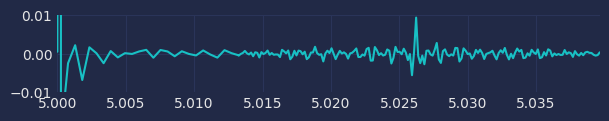

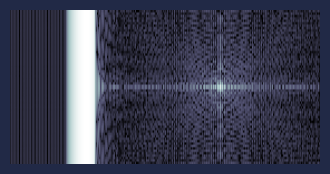

In [7]:
time = gtime([[1e-1, 50], [1e-5, 26], [5e-4, 26], [15e-5, 176]])
plt.figure(figsize=(7,1))
plt.plot(time, efm[:, 12])
plt.xlim(4.99999, time[-1])
plt.ylim(-1e-2, 1e-2)
plt.show()

plt.figure(figsize=(4,2))
plt.imshow((efm[:, :].T.abs() + 1e-4).log(), aspect='auto', cmap=plt.cm.bone)
plt.axis(False)
plt.show()

In [8]:
se_data = efm[-176:, :].T
time = torch.linspace(0., 15e-5 * 176, 176)
se_data.shape, time.shape

(torch.Size([64, 176]), torch.Size([176]))

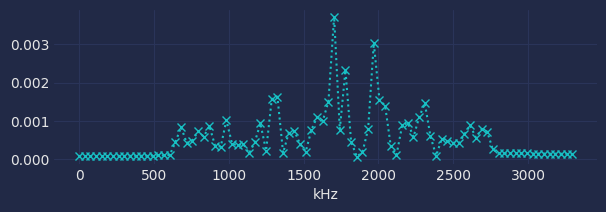

torch.Size([56, 56])


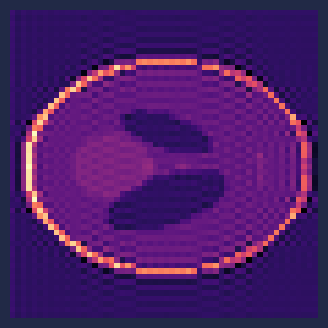

In [9]:
spin_densities = torch.fft.ifftshift(torch.fft.fftn(se_data, dim=(-1,-2)), dim=-2)
freq = torch.fft.fftfreq(se_data.shape[1], d=(time[-1] - time[0]) / time.shape[0])

freq = freq[:freq.shape[0]//2]
spin_densities = spin_densities[:, :spin_densities.shape[1]//2].abs()
spin_densities.shape

fl, fh = (40 - Gx.max().item()) * gyromagnetic_ratio, (40 + Gx.max().item()) * gyromagnetic_ratio
plt.figure(figsize=(7,2))
plt.plot(freq, spin_densities[0], 'x:')
# plt.xlim(fl, fh)
plt.xlabel('kHz')
plt.show()

sd = spin_densities[17//4:-17//4+1, (freq - fl).abs().argmin():(freq - fh).abs().argmin()]
print(sd.shape)
plt.figure(figsize=(4,4))
plt.imshow(sd, aspect='equal', cmap=plt.cm.magma)
plt.axis(False)
plt.show()

In [10]:
time = torch.linspace(-15e-5 * 88, 15e-5 * 88, 176)
se = se_data * (2j * math.pi * 120 * gyromagnetic_ratio * time).exp()
baseband = torch.fft.ifftshift(torch.fft.fftn(se_data, dim=(-1,-2)), dim=-2)
baseband = baseband[17//4:-17//4+1, (freq - fl).abs().argmin():(freq - fh).abs().argmin()]
ks = torch.fft.ifftn(torch.fft.ifftshift(baseband, dim=(-1,-2)), dim=(-1,-2))
sd = torch.fft.ifftshift(torch.fft.fftn(ks, dim=(-1,-2)), dim=(-1,-2))
ks.shape, sd.shape

(torch.Size([56, 56]), torch.Size([56, 56]))

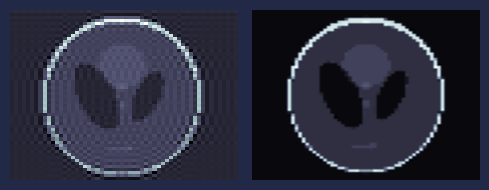

In [11]:
fig, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].imshow(sd.abs().T.flip(1), aspect='auto', cmap=plt.cm.bone)
ax[0].axis(False)
ax[1].imshow(rho_map, aspect='auto', cmap=plt.cm.bone)
ax[1].axis(False)
plt.tight_layout()
plt.show()

In [12]:
t = torch.linspace(-15e-5 * 88, 15e-5 * 88, 56).cuda()
phases = torch.linspace(-.99, .99, 56)[:, None, None]
x = torch.linspace(-1.0, 1.0, 56) # x [m]
y = torch.linspace(-1.0, 1.0, 56) # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')
Gx = X[None, :, :] * torch.ones_like(phases)
Gx *= 100 / 4
Gx[:2] = 0
Gy = Y[None, :, :] * phases
Gy *= 100 / 4
Gy[:2] = 0
Gx = Gx.cuda()
Gy = Gy.cuda()

In [13]:
Gx.shape, ks.shape

(torch.Size([56, 56, 56]), torch.Size([56, 56]))

In [14]:
m_est = torch.zeros_like(Gx[0]).view(-1, 1).cfloat().cuda()

for i in tqdm(range(5)):
    for j in range(Gx.shape[0]):
        E = (2j * math.pi * gyromagnetic_ratio * (Gx[j] * t[:, None, None, None] - Gy[j] / (0.3 * 2 * math.pi * gyromagnetic_ratio))).exp().transpose(0,1)
        E = E.flatten(2).flatten(0,1)
        update = (((ks[j].view(-1, 1).cuda() - E @ m_est.cfloat()) / E.norm(p=2, dim=1, keepdim=True)).T * E.T.conj()).mean(-1).view(-1, 1)
        m_est = m_est + 9e-3 * update# / update.norm(p=2)

100%|██████████| 5/5 [00:00<00:00, 27.74it/s]


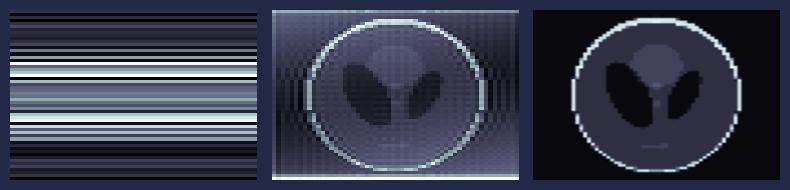

In [15]:
fig, ax = plt.subplots(1,3,figsize=(8,2))
ax[0].imshow(update.cpu().reshape_as(Gx[0]).abs(), aspect='auto', cmap=plt.cm.bone)
ax[0].axis(False)
ax[1].imshow(m_est.cpu().reshape_as(Gx[0]).abs(), aspect='auto', cmap=plt.cm.bone, vmax=m_est.abs().quantile(0.99))
ax[1].axis(False)
ax[2].imshow(rho_map, aspect='auto', cmap=plt.cm.bone)
ax[2].axis(False)
plt.tight_layout()
plt.show()